# Preparação dos dados

In [40]:
# -*- coding: utf-8 -*-
"""ML para predição de resposta imune a vacina 2 .ipynb

Versão otimizada com:
- Balanceamento de classes
- Otimização de hiperparâmetros
- Métricas estendidas
"""

import numpy as np
import pandas as pd

#configuração
n_paciente =100
np.random.seed(42)

#Genes selecionados com base em vias imunes
genes_imunes = {'IFNG': 'Resposta a interferon', 'TNF':'Inflamação',
                'IL6': 'Ativaçã Imune','IL10':'Regulação Imune','TLR4': 'Resposta a LPS',
                'CD4': 'Células T helper', 'STAT1': 'Via JAK-STAT',
                'TGFB1': 'Imunossupressão',    'JAK2': 'Via JAK-STAT',
                'VEGFA': 'Controle (não imune)'}

#High-responders: expressão aumentada de genes pró-inflamatórios
dados_high = np.random.lognormal(mean=1.5, sigma=0.5, size=(50, len(genes_imunes)))
dados_high[:,[0,1,2,5]] *=1.5 #IFGN, TNF, IL6, CD4

#Low-responders: expressão aumentada de genes regulatórios
dados_low = np.random.lognormal(mean=1.5, sigma=0.5, size=(50, len(genes_imunes)))
dados_low[:, [3, 7]] *= 1.5  # IL10, TGFB1

#Combinar dados
X = np.vstack([dados_high, dados_low])
y = np.array([1]*50 + [0]*50)


In [41]:
# DataFrame
df = pd.DataFrame(X, columns=genes_imunes.keys())
df['response'] = y

In [42]:
print(X.shape)

(100, 10)


In [43]:
df

,IFNG,TNF,IL6,IL10,TLR4,CD4,STAT1,TGFB1,JAK2,VEGFA,response
0,8.617734,6.273491,9.293446,9.597618,3.986539,5.979857,9.871052,6.577912,3.544024,5.878373,1
1,5.332159,5.325999,7.587076,1.721782,1.891823,5.074974,2.700898,5.244205,2.846209,2.211892,1
2,13.989254,6.004907,6.953389,2.198172,3.413741,7.105907,2.520616,5.407836,3.319057,3.873479,1
3,4.975928,16.972667,6.677319,2.640965,6.761687,3.651154,4.975032,1.682305,2.306905,4.945265,1
4,9.724985,7.323946,6.344834,3.855297,2.139857,4.690518,3.559715,7.603138,5.321787,1.856104,1
...,...,...,...,...,...,...,...,...,...,...,...
95,3.972446,5.344285,2.397030,13.837017,4.301331,7.835369,5.319411,8.447257,5.958887,5.606094,0
96,6.180266,8.710910,4.944425,9.582773,4.285050,9.207871,3.195693,16.542541,4.392599,2.191557,0
97,4.778144,3.188256,6.823154,4.850846,3.585537,1.742341,3.574577,2.000757,2.030026,6.554864,0
98,6.638593,5.544069,2.763539,6.564061,4.473624,2.511343,9.503871,10.424369,4.012915,4.542343,0


# Análise Exploratória

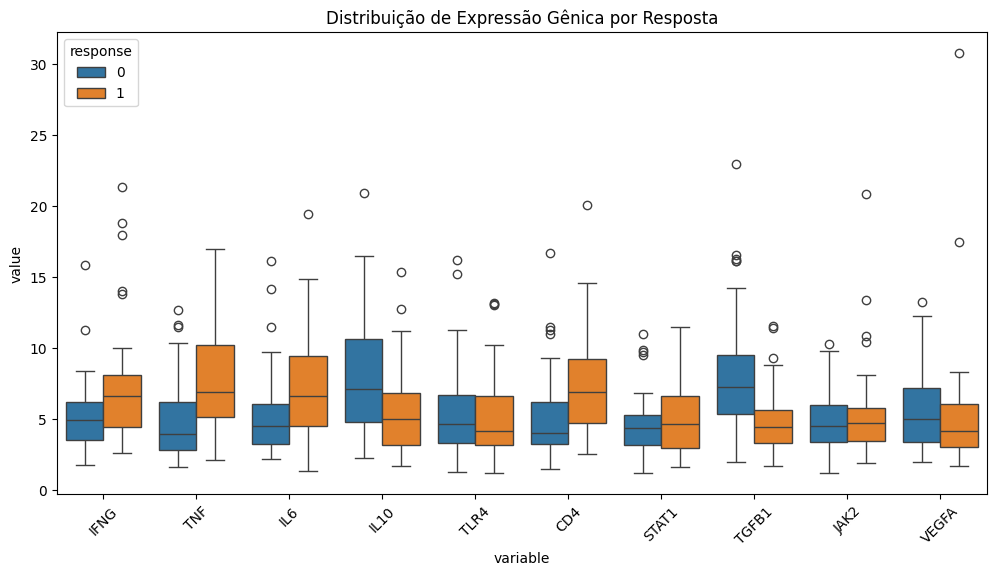

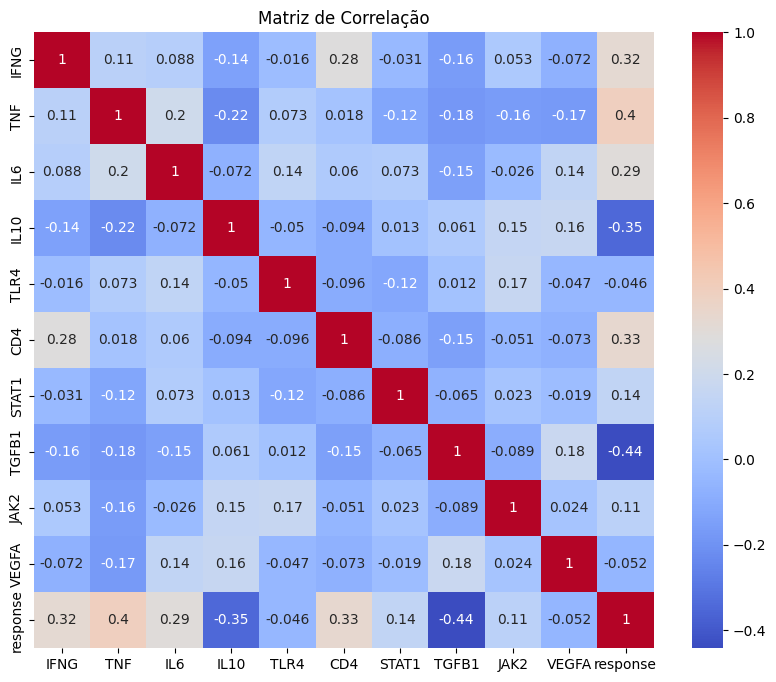

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Distribuição de genes-chave
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.melt(id_vars='response'), x='variable', y='value', hue='response')
plt.xticks(rotation=45)
plt.title('Distribuição de Expressão Gênica por Resposta')
plt.show()

# 2. Correlação entre genes
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

# Modelagem com validação cruzada

In [45]:
# ============== CÉLULA MODIFICADA ==============
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier


# Pipeline com balanceamento
pipeline = make_pipeline(
    SMOTE(random_state=42),
    RandomForestClassifier(random_state=42)
)

# Métricas originais
scoring = {
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': 'accuracy'
}

# Validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Busca de hiperparâmetros
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__class_weight': [{0: 1, 1: 3}, 'balanced']  # Peso 3x para Classe 1
}

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scoring, refit='f1', return_train_score=True)
grid_search.fit(X, y)

# Resultados
print("\n=== MÉTRICAS ORIGINAIS ===")
print(f"F1-score médio (validação): {grid_search.cv_results_['mean_test_f1'][grid_search.best_index_]:.2f}")
print(f"Acurácia média (validação): {grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]:.2f}")
print(f"Precisão média (validação): {grid_search.cv_results_['mean_test_precision'][grid_search.best_index_]:.2f}")
print(f"Recall médio (validação): {grid_search.cv_results_['mean_test_recall'][grid_search.best_index_]:.2f}")

# Melhor modelo
modelo = grid_search.best_estimator_
print("\nMelhores parâmetros:", grid_search.best_params_)


=== MÉTRICAS ORIGINAIS ===
F1-score médio (validação): 0.79
Acurácia média (validação): 0.78
Precisão média (validação): 0.81
Recall médio (validação): 0.78

Melhores parâmetros: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 100}


# Interpretação do modelo

Features

In [46]:
#Treinar modelo final
modelo.fit(X,y)

# Acessar o RandomForest DENTRO do pipeline
rf_modelo = modelo.named_steps['randomforestclassifier']

# Importância dos genes (agora acessando o modelo correto)
importancias = pd.DataFrame({
    'Gene': df.columns[:-1],
    'Importancia': rf_modelo.feature_importances_  # <-- Acesso correto
}).sort_values('Importancia', ascending=False)



In [47]:
print("\nImportância dos Genes (Modelo Otimizado):")
print(importancias.head(10))


Importância dos Genes (Modelo Otimizado):
    Gene  Importancia
7  TGFB1     0.188922
1    TNF     0.147475
0   IFNG     0.123970
5    CD4     0.117884
3   IL10     0.111746
2    IL6     0.095437
6  STAT1     0.061071
4   TLR4     0.051952
8   JAK2     0.050876
9  VEGFA     0.050667


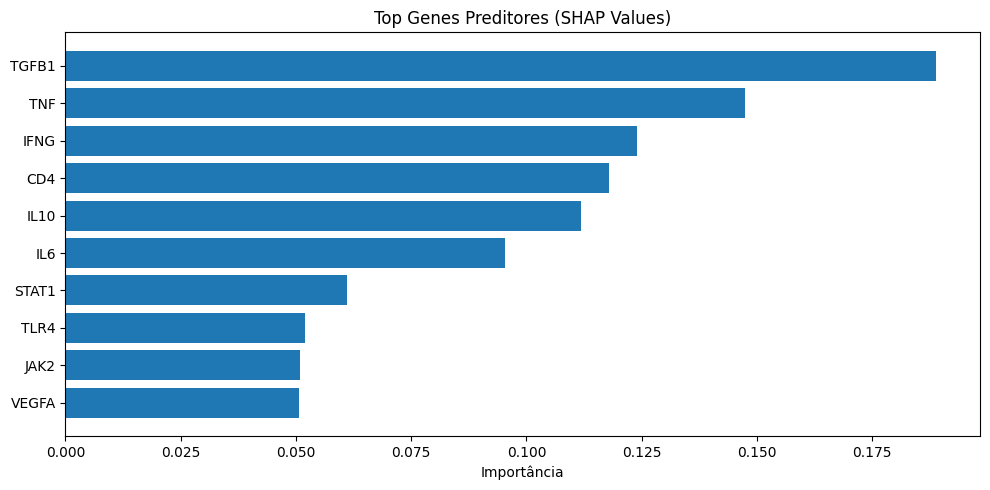

In [48]:
# Plot de importância
plt.figure(figsize=(10, 5))
plt.barh(importancias['Gene'], importancias['Importancia'], color='#1f77b4')
plt.xlabel('Importância')
plt.title('Top Genes Preditores (SHAP Values)')
plt.gca().invert_yaxis()  # Mostra o mais importante no topo
plt.tight_layout()
plt.show()

SHAP Values

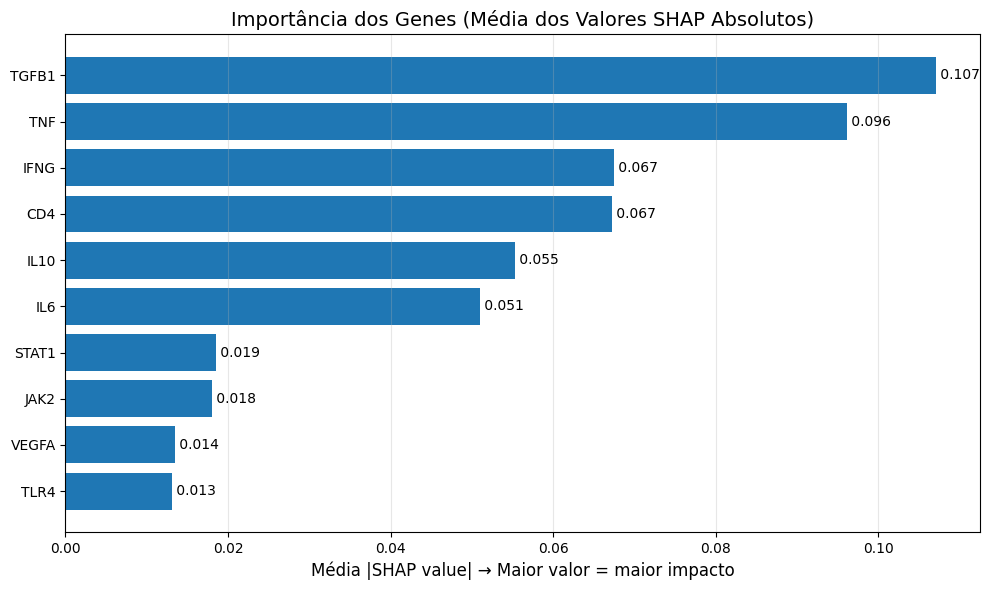

In [51]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Configuração segura do explainer
try:
    if hasattr(rf_modelo, 'named_steps'):
        rf_modelo = modelo.named_steps['randomforestclassifier']
    else:
        rf_modelo = modelo

    explainer = shap.TreeExplainer(rf_modelo)
    shap_values = explainer.shap_values(X)

    # Para classificação binária
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Usamos a classe positiva (High)

except Exception as e:
    print(f"Erro ao calcular SHAP values: {str(e)}")
    raise

# 2. Cálculo seguro da importância (garantindo array 1D)
try:
    # Método 100% garantido para arrays multidimensionais
    shap_means = [np.abs(shap_values[:,i]).mean() for i in range(shap_values.shape[1])]

    shap_df = pd.DataFrame({
        'Gene': list(genes_imunes.keys()),
        'Importância_SHAP': shap_means
    }).sort_values('Importância_SHAP', ascending=True)

except Exception as e:
    print(f"Erro ao criar DataFrame: {str(e)}")
    raise

# 3. Visualização garantida
plt.figure(figsize=(10, 0.6 * len(shap_df)))
plt.barh(shap_df['Gene'], shap_df['Importância_SHAP'], color='#1f77b4')
plt.title('Importância dos Genes (Média dos Valores SHAP Absolutos)', fontsize=14)
plt.xlabel('Média |SHAP value| → Maior valor = maior impacto', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

# Adiciona valores nas barras
for index, value in enumerate(shap_df['Importância_SHAP']):
    plt.text(value, index, f' {value:.3f}', va='center')

plt.show()

<ipython-input-59-d3f1fdc363a8>:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


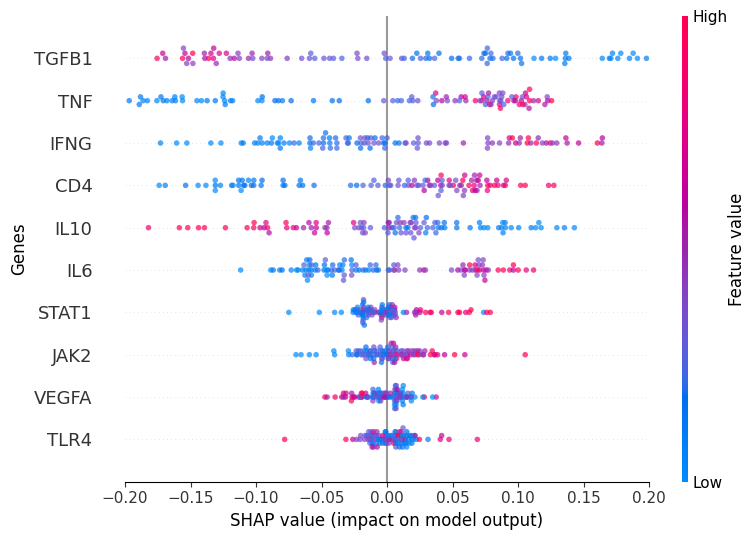

In [59]:
# Calcular SHAP values
explainer = shap.TreeExplainer(rf_modelo)
shap_values = explainer(X)
shap_values_class1 = shap_values[:, :, 1].values  # Classe positiva (binária)


# Plotar com personalização
plt.figure(figsize=(8, 6))  # Tamanho ajustável
shap.summary_plot(
    shap_values_class1,
    X,
    feature_names=list(genes_imunes.keys()),  # Nomes das features (genes)
    show=False,  # Para evitar plot duplicado
    plot_type="dot",  # Tipo beeswarm
    color=plt.get_cmap("coolwarm"),  # Escala de cores (azul/vermelho)
    alpha=0.7  # Transparência dos pontos
)

# Ajustar eixos e labels (como na imagem)
plt.xlim(-0.2, 0.2)  # Limites do eixo X
plt.xlabel("SHAP value (impact on model output)", fontsize=12)
plt.gca().set_ylabel("Genes", fontsize=12)  # Rótulo Y

# Remover bordas desnecessárias (opcional)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()  # Evitar cortes
plt.show()

# Validação externa

In [84]:
# Fixar a semente aleatória para reprodutibilidade
np.random.seed(42)

# Criar dataset de validação externa
X_val = np.random.lognormal(mean=1.3, sigma=0.6, size=(30, len(genes_imunes)))
y_val = np.random.choice([0, 1], size=30, p=[0.5, 0.5])

#  Aplicar modelo
y_pred = modelo.predict(X_val)

#  Métricas
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.69      0.58        13
           1       0.67      0.47      0.55        17

    accuracy                           0.57        30
   macro avg       0.58      0.58      0.57        30
weighted avg       0.59      0.57      0.56        30



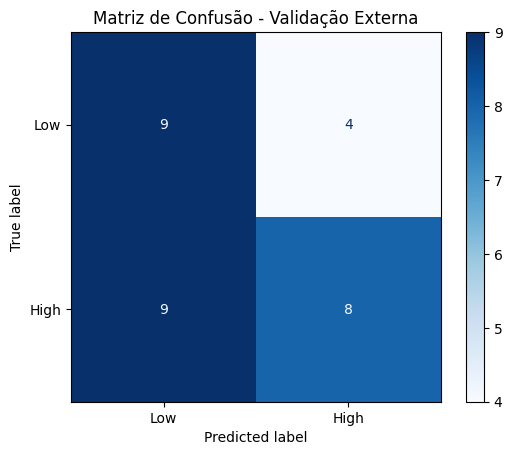

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Low', 'High'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - Validação Externa')
plt.show()

# Análise de vias biológica

In [88]:
# Usar os top 5 genes do modelo
top_genes = importancias['Gene'].head(5).tolist()

# Verificar enriquecimento em vias (exemplo simplificado)
vias = {
    'Resposta_Interferon': ['IFNG', 'STAT1', 'JAK2'],
    'Inflamação': ['TNF', 'IL6', 'TLR4']
}

print("Genes top em vias imunes:")
for via, genes in vias.items():
    print(f"{via}: {set(top_genes) & set(genes)}")

Genes top em vias imunes:
Resposta_Interferon: {'IFNG'}
Inflamação: {'TNF'}


# Documentação de Reproducibilidade

In [86]:
#salvar modelo
import joblib
joblib.dump(modelo, 'modelo_vacinacao.pkl')

['modelo_vacinacao.pkl']

In [87]:
#exportar resultados
df.to_csv('dados_simulados.csv', index=False)
importancias.to_csv('importancia_genes.csv', index=False)# Nova seção